# Post-processing continuous TG ApRES data
The aim of this notebook is to convert al the dat files from each continuous (attended) ApRES dataset from Thwaites into a zarr store on the google bucket, while also computing the profiles (fft) and stacking (.mean(dim='chirp_num'). 

The following steps are performed for each dataset:

- load all the dat file using xapres.load_all
- save that to a zarr directory locally
- rechunk that zarr using rechunker to `{'chirp_time': -1, 'chirp_num': 10}` and save on the google bucket at `/SITE_NAME/zarr/rechunked.zarr`
- load the result lazily then add the profiles, add the stacked profiles and the stacked chirps,
- save the result as `/SITE_NAME/zarr/full.zarr`

This has been run for the following three sites where I found that the dat files had been collected together in a file called `dats`:

- ApRES_LTG
- ApRES_Lake1
- ApRES_Lake2

## Summary
This NB produced the following three zarr stores:
- gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr
- gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_Lake1/zarr/full.zarr
- gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_Lake2/zarr/full.zarr

They can be loaded with, for example:
```
import xarray as xr
f = 'gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr'
ds = xr.open_dataset(f, engine = 'zarr', chunks = {})
```

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45671")
client

<Client: 'tcp://127.0.0.1:45671' processes=10 threads=10, memory=74.18 GiB>

In [1]:
from rechunker import rechunk
from dask.diagnostics import ProgressBar
from dask.distributed import performance_report
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append("/home/jovyan/xapres/")
import xapres as xa
import numpy as np
import xarray as xr
import zarr
import os
import json
import fsspec


In [6]:
tg_1 = xa.load.from_dats()

In [7]:
site = "ApRES_LTG"
#site = "ApRES_Lake1"
#site = "ApRES_Lake2"
root = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site}"
dat_directory = root + "/dat_files"
filepaths = tg_1.list_files(directory=dat_directory)

In [8]:
print(f"there are {len(filepaths)} files from {site}")

there are 181 files from ApRES_LTG


In [17]:
one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False)

100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


In [18]:
print(f"total size of dataset without profiles computed = {one_dat.nbytes/1e9 * len(filepaths):.2f} GB")

total size of dataset without profiles computed = 11.64 GB


In [10]:
ds = tg_1.load_all(directory = dat_directory, computeProfiles = False, file_numbers_to_process=list(range(0,5)))

100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


<xarray.DataArray 'time' (time: 12)> Size: 96B
array(['2023-01-16T05:42:03.000000000', '2023-01-16T05:53:54.000000000',
       '2023-01-16T06:05:31.000000000', '2023-01-16T06:20:39.000000000',
       '2023-01-17T06:20:25.000000000', '2023-01-18T06:20:33.000000000',
       '2023-01-19T06:20:25.000000000', '2023-01-20T06:20:45.000000000',
       '2023-01-21T06:21:06.000000000', '2023-01-22T06:20:56.000000000',
       '2023-01-23T06:20:56.000000000', '2023-01-24T06:20:56.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 96B 2023-01-16T05:42:03 ... 2023-01-2...
    filename      (time) <U92 4kB 'gs://ldeo-glaciology/apres/thwaites/contin...
    burst_number  (time) int64 96B 0 0 0 0 1 2 3 4 5 6 0 1
    orientation   (time) <U7 336B 'unknown' 'unknown' ... 'unknown' 'unknown'

In at least one of the sites, the first few dat files contain data collected using different attenuator settings, so we skip those, because they cant easily be concatenated with the rest of the data and they are likely just test shots taken on the day of installation. 

In another site some dat files are from much earlier (2002?)

In [11]:
if site == 'ApRES_Lake1':
    start_dat_file_number = 3  # the first 3 use different attenuator settings. 
elif site == 'ApRES_LTG': 
    start_dat_file_number = 4  # the first 4 use te same attenuator settings, but they are not regularly spaces in time with the other data
elif site == 'ApRES_Lake2':
    start_dat_file_number = 3

In [8]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})

## Load all and save to zarr
Load all the data from this site into local memory, without computing the profiles, then save it back to local sotrage as a zarr. 

Computing all the profiles is an expensive operation, so we would like to use a dask cluster. But to use the cluster, this needs to be a dask array. This is a way of solving that because the zarr that it creates can be loaded to get the data loaded lazily. 



In [12]:
raw_ds_location = f'zarrs/{site}'

if site == 'ApRES_Lake2':
    N = (len(filepaths)-start_dat_file_number)//2 + start_dat_file_number 
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(start_dat_file_number, N)))
    ds.to_zarr(raw_ds_location)  
    
    del ds
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(N, len(filepaths))))
    ds.to_zarr(raw_ds_location, append_dim='time')  
    
else:
    
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(start_dat_file_number,len(filepaths))))
    ds.to_zarr(raw_ds_location)
#print(ds.nbytes/1e9)

100%|██████████| 177/177 [08:51<00:00,  3.00s/it]


In [13]:
#with performance_report('report.html'):


## Load from zarr
To get a lazily loaded dataset containing dask arrays, we load from 

In [14]:
r = load_zarr(raw_ds_location)

The result is a dataset containing dask arrays. 


## Rechunk
A remaining issue is that the data is chunked in the `chirp_time` dimension. The fft step of computing the profiles requires the data to not be chunked in this dimension. 

We use rechunker to rechunk to the following chunks sizes: (23, 40001, 10, 1), following this guide: https://rechunker.readthedocs.io/en/latest/tutorial.html#Rechunk-a-Group

First we step up a temporary location to store data and the final target location. For the temp location we use the local disk, for the target locations we make a directory in the google bucket where the data is stored. Note we could also use the scratch bucket in cryocloud if we are running this there. I am not sure if is faster to use that or the 'local' space wheer the notebook is running. Both seem to work ok. 

In [15]:
with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

filename = root + "/zarr/rechunked.zarr"
target_store = fsspec.get_mapper(filename, mode='w', token=token)

# we could use the scratch bucket on cryocloud...
#scratch = os.environ['SCRATCH_BUCKET']
#temp_store = fsspec.get_mapper(scratch + "temp.zarr", mode='w')
# ... or our local space
temp_store = "zarrs_rechunked_temp.zarr"
!rm -rf zarrs_rechunked_temp.zarr

Next, define the source as the zarr that we just wrote, and reload is as `ds` just to be sure we are using exactly the same info as is saved int here for the chunking. 

In [16]:
source_store = raw_ds_location
ds = xr.open_dataset(source_store,
            engine = 'zarr', 
            chunks = {})
source_group = zarr.open(source_store)

Define the chunking scheme. We only want to rechunk the 'chirp'variable'.
We create a dictionay with the data variables and coordinates as keys and `None` for the values, then replace the 'chirp' entry with another dictionary describing the desired chunking. 

In [17]:
target_chunks = {var: None for var in dict(ds.data_vars) | dict(ds.coords)}

chirp_chunk_sizes_dict = {dim: chunks[0] for dim, chunks in zip(ds.chirp.dims, ds.chirp.chunks)}
chirp_chunk_sizes_dict['chirp_time'] = ds.chirp_time.shape[0]
chirp_chunk_sizes_dict['chirp_num'] = 10

target_chunks["chirp"] =  chirp_chunk_sizes_dict
#target_chunks = chirp_chunk_sizes_dict

# need to remove the existing stores or it won't work
!rm -rf zarrs_rechunked/*
array_plan = rechunk(source = source_group, 
                     target_chunks = target_chunks, 
                     max_mem = "200MB", 
                     target_store = target_store,
                     temp_store=temp_store)
array_plan

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [18]:
with ProgressBar():
    array_plan.execute()
zarr.consolidate_metadata(target_store)

<zarr.hierarchy.Group '/'>

In [19]:
r_reload = load_zarr(target_store)
#r_reload.chirp.chunks

Plot the pofiles to estimate an appropriate max_depth to use. 2500 m appears reasonable as the bed is just below 2000m in the plot below. 

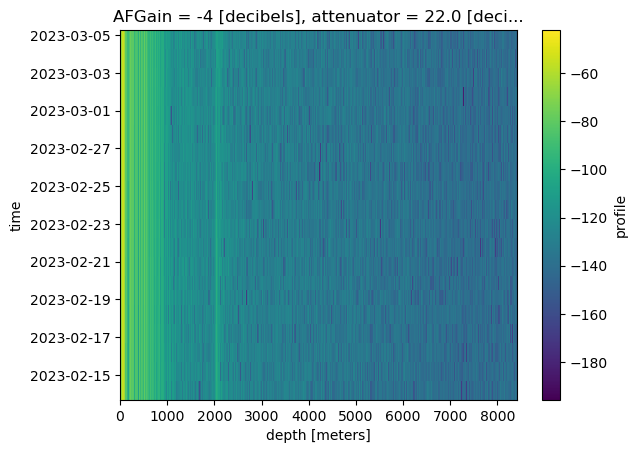

In [20]:
r_reload.chirp.mean(dim='chirp_num').isel(time = slice(30,50)).computeProfile().dB().plot()

## Add profiles
Add profiles to the dataset and compute stacked chirps and profiles. 

In [21]:
full = r_reload.addProfileToDs(max_range = 2500)
profile_stacked = full.profile.mean(dim='chirp_num')
chirp_stacked = full.chirp.mean(dim='chirp_num')
full_stacked = full.assign({'profile_stacked': profile_stacked, 'chirp_stacked': chirp_stacked})

## Write to zarr
Write the final result to a zarr in the google bucket. 

In [22]:
filename = root + '/zarr/full.zarr'
mapper = fsspec.get_mapper(filename, mode='w', token=token)

full_stacked.to_zarr(mapper)

In [23]:
f = load_zarr(mapper)
f

<xarray.Dataset> Size: 18GB
Dimensions:          (attenuator_setting_pair: 1, time: 351, chirp_time: 40001,
                      chirp_num: 100, profile_range: 11889)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U90 126kB dask.array<chunksize=(351,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(351,), meta=np.ndarray>
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * time             (time) datetime64[ns] 3kB 2023-01-16T00:52:00 ... 2023-1...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 11GB dask.array<chunksize=(22, 40001, 10, 1), meta=np.ndarray>
    chirp_stacked    (time, chirp_time, attenuator_setting_pair) float64 112MB dask.array<chunksize=(22, 40001, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 7GB dask.array<chunksize=(22, 10, 1, 11889), meta=np.ndarray>
    profile_stacked  (time, attenuator_setting_pair, profile_range) complex128 67MB dask.array<chunksize=(22, 1, 11889), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-21 15:30:22.044429

In [24]:
print('everything completed ok and you should find ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr in the bucket')

everything completed ok and you should find ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr in the bucket


In [15]:
full_stacked.profile_stacked.load()

<xarray.DataArray 'profile_stacked' (time: 362, attenuator_setting_pair: 1,
                                     profile_range: 11889)> Size: 69MB
array([[[ 6.68002374e-03+0.00000000e+00j,
          3.64323551e-07+5.88457083e-03j,
         -3.97115910e-03+7.95787624e-07j, ...,
         -3.13873729e-07-3.60635519e-07j,
         -1.23389765e-07-4.16351413e-07j,
          5.59941971e-07-5.69340573e-07j]],

       [[ 6.69701978e-03+0.00000000e+00j,
         -1.19533060e-08+5.89933100e-03j,
         -3.98061215e-03+3.29834417e-07j, ...,
         -6.32162487e-07-3.06725506e-07j,
         -1.07168776e-07-5.24138656e-07j,
          3.87862228e-07-6.00727497e-07j]],

       [[ 6.69241659e-03+0.00000000e+00j,
          6.34100040e-08+5.89531487e-03j,
         -3.97798407e-03+4.19429211e-07j, ...,
         -1.93632186e-07-2.46644366e-07j,
          8.28425792e-08-2.96162017e-07j,
          3.76199746e-07-2.23067560e-07j]],
...
       [[ 6.66799118e-03+0.00000000e+00j,
          3.17788725e-06+5.87527973e-03j,
         -3.96721061e-03+4.26932617e-06j, ...,
          9.53348254e-07-6.71366218e-07j,
          9.29607395e-07+5.62604727e-07j,
         -8.86125569e-08+9.09786342e-07j]],

       [[ 6.66627886e-03+0.00000000e+00j,
          3.20669524e-06+5.87380920e-03j,
         -3.96624618e-03+4.25959342e-06j, ...,
          9.02973802e-07-3.31087780e-07j,
          4.74961702e-07+7.07892626e-07j,
         -3.94728744e-07+4.56977899e-07j]],

       [[ 6.66697204e-03+0.00000000e+00j,
          3.21395190e-06+5.87440511e-03j,
         -3.96663790e-03+4.31102171e-06j, ...,
          1.24010024e-06+1.00643497e-07j,
          7.87174834e-08+9.72338634e-07j,
         -5.74623030e-07+3.02553256e-07j]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 8B -14
    attenuator     (attenuator_setting_pair) float64 8B 6.0
    burst_number   (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 1 0 1 0 1 0 1 0 1 0
    filename       (time) <U92 133kB 'gs://ldeo-glaciology/apres/thwaites/con...
    orientation    (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time           (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-01-...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

In [17]:
full_stacked.profile_stacked.nbytes/1e6

69.812208

In [18]:
dB = full_stacked.profile_stacked.isel(time=slice(5,-1)).dB().load()

KeyboardInterrupt: 

In [19]:
dB

<xarray.DataArray 'profile_stacked' (time: 356, attenuator_setting_pair: 1,
                                     profile_range: 11889)> Size: 34MB
array([[[ -43.47478601,  -44.57611776,  -47.99258849, ...,
         -134.26285621, -128.01299281, -122.21411856]],

       [[ -43.47912211,  -44.580411  ,  -47.99670598, ...,
         -126.68280657, -126.50316807, -128.39706169]],

       [[ -43.48366422,  -44.58493209,  -48.00117005, ...,
         -122.41687615, -121.92955264, -122.60269614]],

       ...,

       [[ -43.51903353,  -44.61830927,  -48.02907053, ...,
         -120.1790747 , -124.94936918, -133.7758992 ]],

       [[ -43.52009967,  -44.61942775,  -48.03028984, ...,
         -118.6658709 , -119.27862648, -120.78020606]],

       [[ -43.52233047,  -44.621602  ,  -48.03240165, ...,
         -120.33867279, -121.38644488, -124.3813619 ]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 8B -14
    attenuator     (attenuator_setting_pair) float64 8B 6.0
    burst_number   (time) int64 3kB 1 0 1 0 1 0 1 0 1 0 ... 0 1 0 1 0 1 0 1 0 1
    filename       (time) <U92 131kB 'gs://ldeo-glaciology/apres/thwaites/con...
    orientation    (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time           (time) datetime64[ns] 3kB 2023-01-21T04:22:47 ... 2024-01-...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

In [30]:
site_for_reload = 'ApRES_Lake1'
filename_for_reload = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site_for_reload}/zarr/full.zarr"
mapper = fsspec.get_mapper(filename_for_reload, mode='w', token=token)
r_lake1 = load_zarr(mapper)

site_for_reload = 'ApRES_LTG'
filename_for_reload = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site_for_reload}/zarr/full_2"
mapper = fsspec.get_mapper(filename_for_reload, mode='w', token=token)
r_LTG = load_zarr(mapper)

In [33]:
r_lake1.dims

FrozenMappingWarningOnValuesAccess({'attenuator_setting_pair': 1, 'time': 362, 'chirp_time': 40001, 'chirp_num': 100, 'profile_range': 11889})

In [34]:
r_LTG.dims

FrozenMappingWarningOnValuesAccess({'attenuator_setting_pair': 1, 'time': 355, 'chirp_time': 40001, 'chirp_num': 100, 'profile_range': 11889})

/tmp/ipykernel_6182/1634667285.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


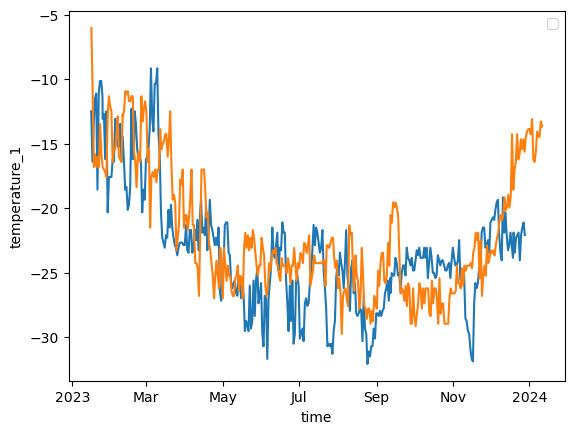

In [42]:
import matplotlib.pyplot as plt
r_LTG.isel(time=slice(4,-1)).temperature_1.plot()
r_lake1.temperature_1.plot()
plt.legend()
